In [ ]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip"

In [0]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [0]:
data_dir = r"/content/A_05_Part_02_Dataset"

In [5]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/testing', transform=test_transforms)


#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
def encoder(a, num_classes):
  labels= torch.nn.functional.one_hot(a, num_classes)
  for i in range(labels[:,0].shape[0]):
    if(labels[:,0][i]==1):
      labels[:,2][i]=1
  return labels.float()

In [0]:
def corona(model, trainloader, validloader, Epochs, name):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    history = []
    for epoch in range(Epochs):  # loop over the dataset multiple times
        total_train = 0
        train_loss = 0.0
        valid_loss = 0.0
        running_loss = 0.0
        correct = 0
        total = 0
        vcorrect = 0
        predicted = []
        train_acc = 0
        valid_acc = 0
        vtotal = 0
        # pbar = tqdm()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            hot_labels = encoder(labels, 3)
            inputs, hot_labels = inputs.to(device), hot_labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs) 
            loss = criterion(outputs, hot_labels)   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                   #----> weights update
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            correct += (outputs == hot_labels).sum().item()
            total += hot_labels.size(0)
            running_loss += loss.item()
            
        for i, data in enumerate(validloader):
            inputs, labels = data
            hot_labels = encoder(labels, 3)
            inputs, hot_labels = inputs.to(device), hot_labels.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs, hot_labels)
            valid_loss += loss.item()
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            vcorrect += (outputs == hot_labels).sum().item()
            vtotal += hot_labels.size(0)

        train_loss = running_loss / len(trainloader)
        valid_loss = valid_loss / len(validloader)
        train_acc = correct / total
        valid_acc = vcorrect / vtotal

        history.append([train_loss, valid_loss, train_acc, valid_acc])
        print('Epoch #', epoch, '\t\tTraining loss: ', train_loss, '\t Validation loss: ', valid_loss)
        print('\t\tTraining Accuracy: ', (100 * train_acc)/3, '\t Validation Accuracy: ', (100 * valid_acc/3))
    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    torch.save(model.state_dict(), './gdrive/My Drive/' + name)
    return model, history

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


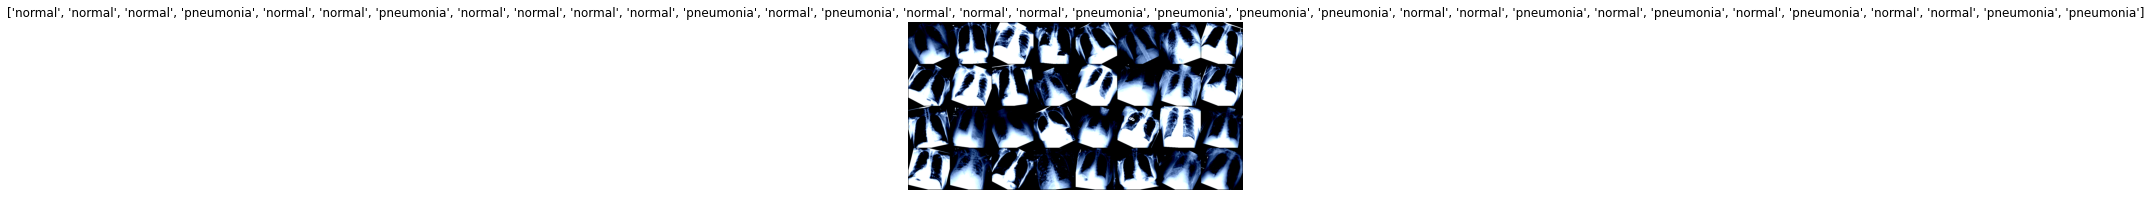

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# Task1 starts here

# Working for VGG here

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.classifier = nn.Sequential(
               nn.Linear(25088, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 3)).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
for param in vgg16.features.parameters():
    param.requires_grad = True
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
model, history = corona(vgg16, trainloader, validloader, Epochs = 20, name = '/vgg16_BCE.pth')

Epoch # 0 		Training loss:  0.26106827404618876 	 Validation loss:  0.185352947935462
		Training Accuracy:  89.12903225806451 	 Validation Accuracy:  92.83439490445859
Epoch # 1 		Training loss:  0.1650070145764609 	 Validation loss:  0.1887102885171771
		Training Accuracy:  93.66129032258065 	 Validation Accuracy:  92.88747346072188
Epoch # 2 		Training loss:  0.1516976814486624 	 Validation loss:  0.14988368451595308
		Training Accuracy:  94.34408602150539 	 Validation Accuracy:  94.26751592356688
Epoch # 3 		Training loss:  0.1355941454236655 	 Validation loss:  0.16312287487089633
		Training Accuracy:  95.05913978494623 	 Validation Accuracy:  94.21443736730362
Epoch # 4 		Training loss:  0.12724155793446548 	 Validation loss:  0.13259730506688355
		Training Accuracy:  95.13978494623655 	 Validation Accuracy:  94.4267515923567
Epoch # 5 		Training loss:  0.12495369176121102 	 Validation loss:  0.1362723920494318
		Training Accuracy:  95.23655913978494 	 Validation Accuracy:  94.798

Text(0.5, 1.0, 'Training and Validation Accuracy')

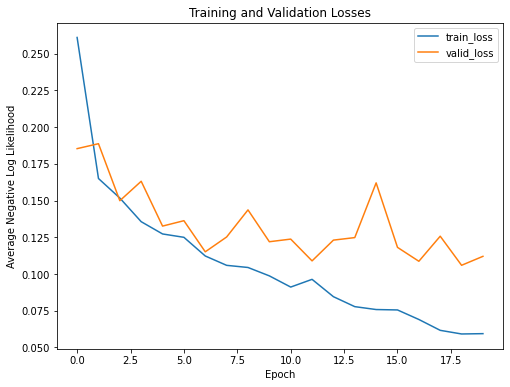

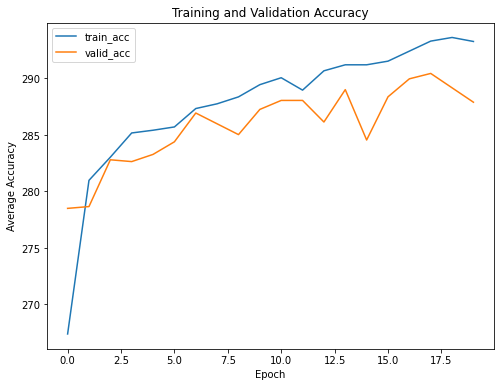

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


F1: 0.6666666666666666


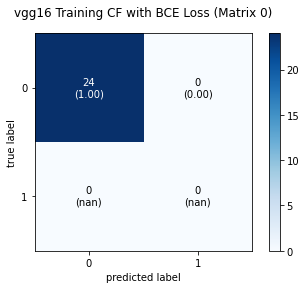

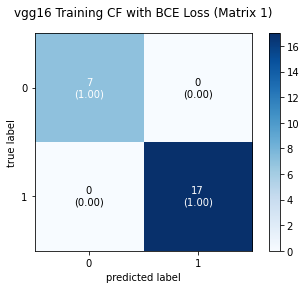

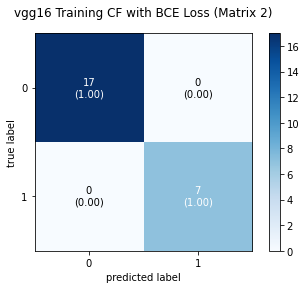

In [0]:
device = torch.device("cuda")
vgg16.to(device)

pr =[]
tl =[]

with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = encoder(classes, 3)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        for i in classes.tolist():
            tl.append(i)
        for j in outputs.tolist():
            pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)

cm = multilabel_confusion_matrix(np.array(tl),np.array(pr))
labels=['Covid-19', 'Normal', 'Pneumonia']
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 2)')
print('F1: {}'.format(f1_score(classes.data.cpu().numpy(), outputs.data.cpu().numpy(), average='macro')))

F1: 0.6286799620132953


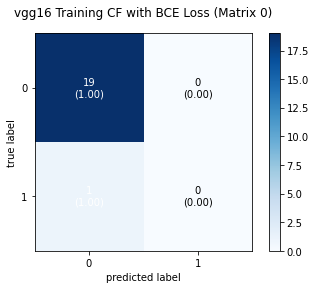

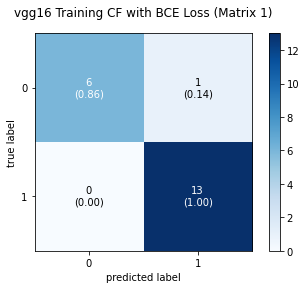

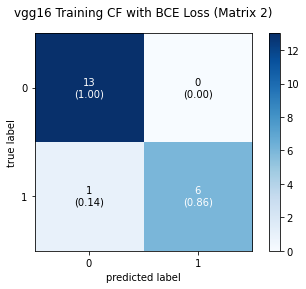

In [0]:
device = torch.device("cuda")
vgg16.to(device)
pr =[]
tl =[]
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = encoder(classes, 3)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        for i in classes.tolist():
            tl.append(i)
        for j in outputs.tolist():
            pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)

cm = multilabel_confusion_matrix(np.array(tl),np.array(pr))

labels=['Covid-19', 'Normal', 'Pneumonia']
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 2)')
print('F1: {}'.format(f1_score(classes.data.cpu().numpy(), outputs.data.cpu().numpy(), average='macro')))

# Working on Resnet here

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True).to(device)
resnet.fc = nn.Sequential(
               nn.Linear(512, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 3)).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [9]:
for param in resnet.parameters():
    param.requires_grad = True
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
model, history = corona(resnet, trainloader, validloader, 20, '/res18_BCE.pth')

Epoch # 0 		Training loss:  0.36141679674079735 	 Validation loss:  0.26451341696083547
		Training Accuracy:  83.31182795698925 	 Validation Accuracy:  90.12738853503186
Epoch # 1 		Training loss:  0.21469911449041562 	 Validation loss:  0.21567235998809337
		Training Accuracy:  91.75806451612904 	 Validation Accuracy:  92.19745222929936
Epoch # 2 		Training loss:  0.18679734676615478 	 Validation loss:  0.1936913788318634
		Training Accuracy:  92.83333333333333 	 Validation Accuracy:  92.67515923566879
Epoch # 3 		Training loss:  0.174964719711198 	 Validation loss:  0.18093329686671494
		Training Accuracy:  93.23118279569893 	 Validation Accuracy:  93.09978768577496
Epoch # 4 		Training loss:  0.15662231110036373 	 Validation loss:  0.165464698523283
		Training Accuracy:  93.8763440860215 	 Validation Accuracy:  93.73673036093419
Epoch # 5 		Training loss:  0.14990339428186417 	 Validation loss:  0.16116290539503098
		Training Accuracy:  93.98387096774194 	 Validation Accuracy:  93.7

Text(0.5, 1.0, 'Training and Validation Accuracy')

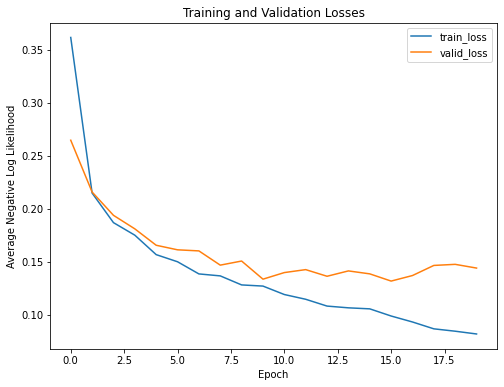

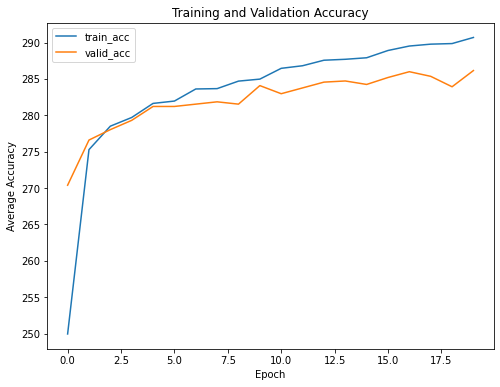

In [10]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

F1: 0.9642579642579642


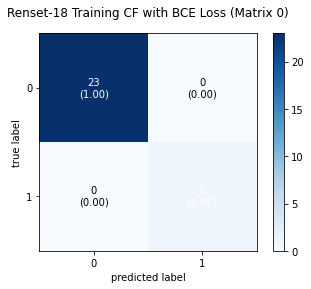

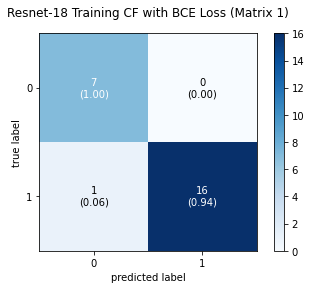

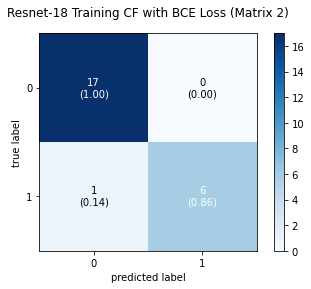

In [11]:
device = torch.device("cuda")
resnet.to(device)

pr =[]
tl =[]

with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = encoder(classes, 3)
        classes = classes.to(device)
        outputs = resnet(inputs)
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        for i in classes.tolist():
            tl.append(i)
        for j in outputs.tolist():
            pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)

cm = multilabel_confusion_matrix(np.array(tl),np.array(pr))
labels=['Covid-19', 'Normal', 'Pneumonia']
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Renset-18 Training CF with BCE Loss (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet-18 Training CF with BCE Loss (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet-18 Training CF with BCE Loss (Matrix 2)')
print('F1: {}'.format(f1_score(classes.data.cpu().numpy(), outputs.data.cpu().numpy(), average='macro')))

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


F1: 0.5643648763853367


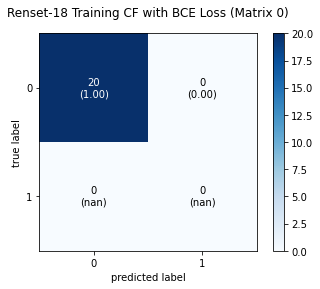

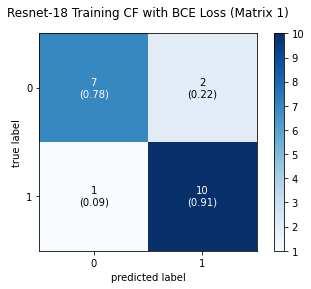

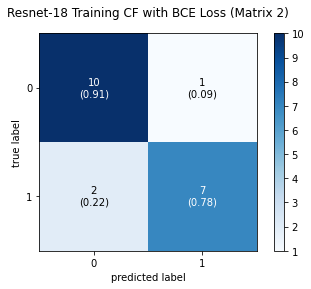

In [12]:
device = torch.device("cuda")
resnet.to(device)
pr =[]
tl =[]

with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = encoder(classes, 3)
        classes = classes.to(device)
        outputs = resnet(inputs)
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        for i in classes.tolist():
            tl.append(i)
        for j in outputs.tolist():
            pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)

cm = multilabel_confusion_matrix(np.array(tl),np.array(pr))
labels=['Covid-19', 'Normal', 'Pneumonia']
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Renset-18 Training CF with BCE Loss (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet-18 Training CF with BCE Loss (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet-18 Training CF with BCE Loss (Matrix 2)')
print('F1: {}'.format(f1_score(classes.data.cpu().numpy(), outputs.data.cpu().numpy(), average='macro')))

# Task2 Using Focal Loss

# VGG working here

In [0]:
def focal_loss(targets,logits,eps,l):
  ce_loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction= 'none')
  pt = torch.exp(-ce_loss)
  loss = (eps * (1-pt)**l * ce_loss).mean()
  return loss

In [0]:
def corona_with_focal(model, trainloader, validloader, Epochs, name):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    history = []
    for epoch in range(Epochs):  # loop over the dataset multiple times
        total_train = 0
        train_loss = 0.0
        valid_loss = 0.0
        running_loss = 0.0
        correct = 0
        total = 0
        vcorrect = 0
        predicted = []
        train_acc = 0
        valid_acc = 0
        vtotal = 0
        # pbar = tqdm()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            hot_labels = encoder(labels, 3)
            inputs, hot_labels = inputs.to(device), hot_labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(inputs) 
            loss = focal_loss(hot_labels, outputs, 0.25, 2 )   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                   #----> weights update
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            correct += (outputs == hot_labels).sum().item()
            total += hot_labels.size(0)
            running_loss += loss.item()

        for i, data in enumerate(validloader):
            inputs, labels = data
            hot_labels = encoder(labels, 3)
            inputs, hot_labels = inputs.to(device), hot_labels.to(device)
            outputs = model(inputs) 
            loss = loss = focal_loss(hot_labels, outputs, 0.2, 2 )
            valid_loss += loss.item()
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            vcorrect += (outputs == hot_labels).sum().item()
            vtotal += hot_labels.size(0)

        train_loss = running_loss / len(trainloader)
        valid_loss = valid_loss / len(validloader)
        train_acc = correct / total
        valid_acc = vcorrect / vtotal

        history.append([train_loss, valid_loss, train_acc, valid_acc])
        print('Epoch #', epoch, '\t\tTraining loss: ', train_loss, '\t Validation loss: ', valid_loss)
        print('\t\tTraining Accuracy: ', (100 * train_acc)/3, '\t Validation Accuracy: ', (100 * valid_acc/3))
    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    torch.save(model.state_dict(), './gdrive/My Drive/' + name)
    return model, history

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.classifier = nn.Sequential(
               nn.Linear(25088, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 3)).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [18]:
for param in vgg16.parameters():
    param.requires_grad = True
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
model, history = corona_with_focal(vgg16, trainloader, validloader, Epochs = 20, name = '/vgg16_Focal_Loss.pth')

Epoch # 0 		Training loss:  0.008089171531706204 	 Validation loss:  0.007087351038353518
		Training Accuracy:  94.26881720430107 	 Validation Accuracy:  93.84288747346072
Epoch # 1 		Training loss:  0.008069793276066325 	 Validation loss:  0.006988990237005055
		Training Accuracy:  94.20430107526882 	 Validation Accuracy:  93.47133757961784
Epoch # 2 		Training loss:  0.007919748719378384 	 Validation loss:  0.007284316438017413
		Training Accuracy:  94.22580645161291 	 Validation Accuracy:  94.47983014861995
Epoch # 3 		Training loss:  0.007773030222844831 	 Validation loss:  0.006761748506687581
		Training Accuracy:  94.3494623655914 	 Validation Accuracy:  94.37367303609341
Epoch # 4 		Training loss:  0.007630891913725736 	 Validation loss:  0.006785229744855315
		Training Accuracy:  94.48387096774194 	 Validation Accuracy:  94.05520169851381
Epoch # 5 		Training loss:  0.007575368190654698 	 Validation loss:  0.006606836523860693
		Training Accuracy:  94.53225806451614 	 Validatio

Text(0.5, 1.0, 'Training and Validation Accuracy')

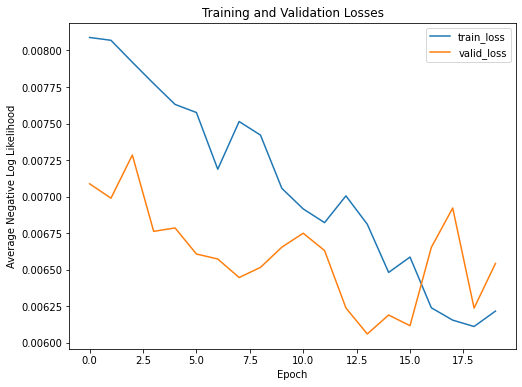

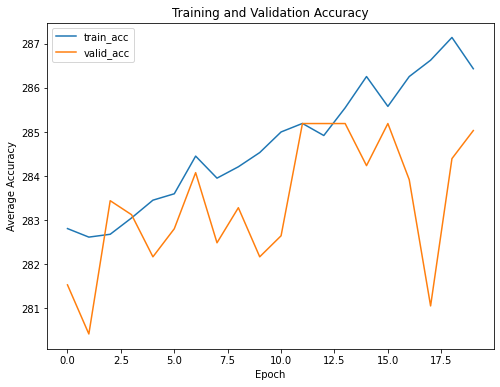

In [19]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

F1: 1.0


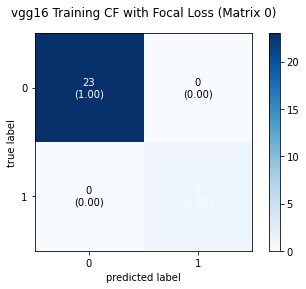

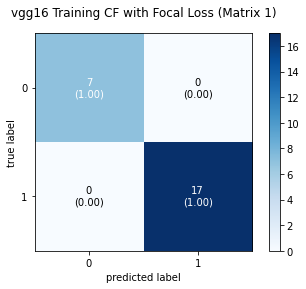

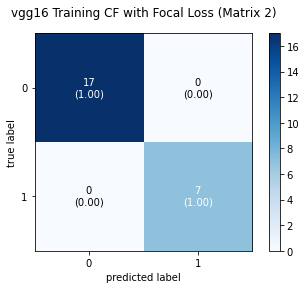

In [20]:
device = torch.device("cuda")
vgg16.to(device)
pr =[]
tl =[]
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = encoder(classes, 3)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        for i in classes.tolist():
            tl.append(i)
        for j in outputs.tolist():
            pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)

cm = multilabel_confusion_matrix(np.array(tl),np.array(pr))

labels=['Covid-19', 'Normal', 'Pneumonia']
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 2)')
print('F1: {}'.format(f1_score(classes.data.cpu().numpy(), outputs.data.cpu().numpy(), average='macro')))

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


F1: 0.6010256410256409


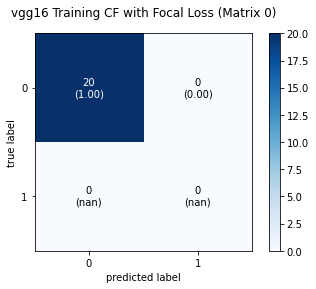

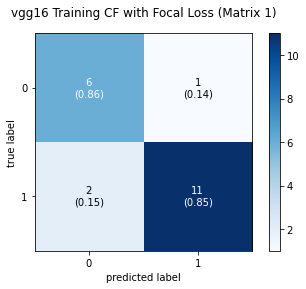

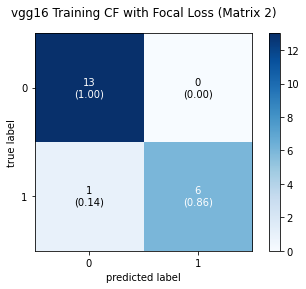

In [21]:
device = torch.device("cuda")
vgg16.to(device)
pr =[]
tl =[]
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = encoder(classes, 3)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        for i in classes.tolist():
            tl.append(i)
        for j in outputs.tolist():
            pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)

cm = multilabel_confusion_matrix(np.array(tl),np.array(pr))

labels=['Covid-19', 'Normal', 'Pneumonia']
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('vgg16 Training CF with BCE Loss (Matrix 2)')
print('F1: {}'.format(f1_score(classes.data.cpu().numpy(), outputs.data.cpu().numpy(), average='macro')))

# Resnet Start here

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
resnet = models.resnet18(pretrained=True).to(device)
resnet.fc = nn.Sequential(
               nn.Linear(512, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 3)).to(device)

In [23]:
for param in resnet.parameters():
    param.requires_grad = True
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
model, history = corona_with_focal(resnet, trainloader, validloader, 20, '/res18_Focal_Loss.pth')

Epoch # 0 		Training loss:  0.03410597476801 	 Validation loss:  0.024902501329779624
		Training Accuracy:  65.5967741935484 	 Validation Accuracy:  65.18046709129511
Epoch # 1 		Training loss:  0.028705528399609413 	 Validation loss:  0.02321017412468791
		Training Accuracy:  65.75268817204301 	 Validation Accuracy:  65.44585987261146
Epoch # 2 		Training loss:  0.026492132766882785 	 Validation loss:  0.02168683297932148
		Training Accuracy:  68.12903225806453 	 Validation Accuracy:  67.72823779193207
Epoch # 3 		Training loss:  0.024522353645375708 	 Validation loss:  0.02016274267807603
		Training Accuracy:  72.51075268817205 	 Validation Accuracy:  71.60297239915074
Epoch # 4 		Training loss:  0.022677082299571678 	 Validation loss:  0.018612697999924422
		Training Accuracy:  75.66129032258065 	 Validation Accuracy:  76.32696390658174
Epoch # 5 		Training loss:  0.020732970596243117 	 Validation loss:  0.01754886470735073
		Training Accuracy:  77.98387096774194 	 Validation Accura

Text(0.5, 1.0, 'Training and Validation Accuracy')

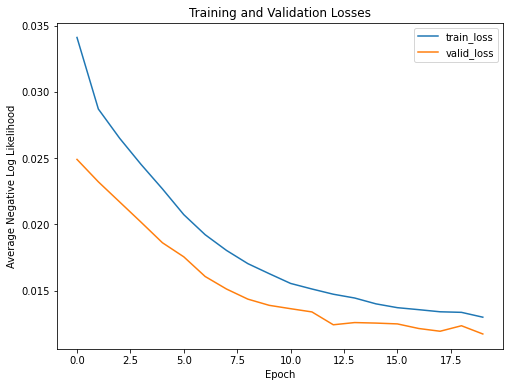

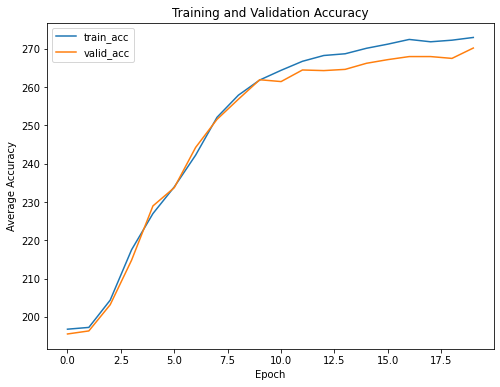

In [24]:

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


F1: 0.5915032679738562


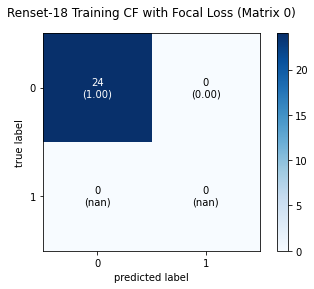

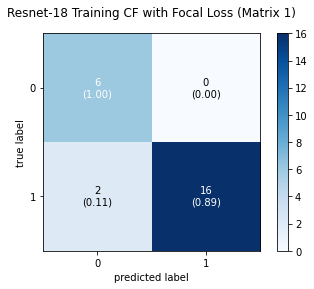

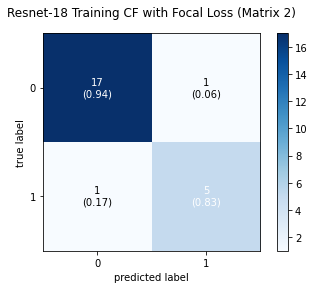

In [25]:
device = torch.device("cuda")
resnet.to(device)

pr =[]
tl =[]

with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = encoder(classes, 3)
        classes = classes.to(device)
        outputs = resnet(inputs)
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        for i in classes.tolist():
            tl.append(i)
        for j in outputs.tolist():
            pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)

cm = multilabel_confusion_matrix(np.array(tl),np.array(pr))
labels=['Covid-19', 'Normal', 'Pneumonia']
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Renset-18 Training CF with BCE Loss (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet-18 Training CF with BCE Loss (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet-18 Training CF with BCE Loss (Matrix 2)')
print('F1: {}'.format(f1_score(classes.data.cpu().numpy(), outputs.data.cpu().numpy(), average='macro')))

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


F1: 0.5393939393939394


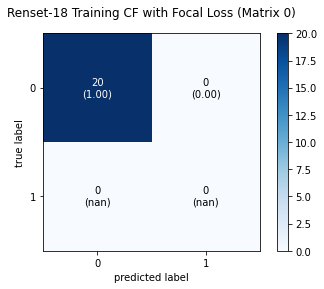

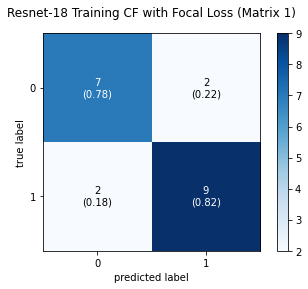

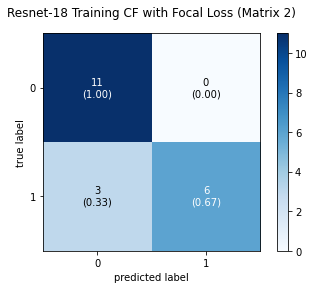

In [26]:
device = torch.device("cuda")
resnet.to(device)

pr =[]
tl =[]

with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = encoder(classes, 3)
        classes = classes.to(device)
        outputs = resnet(inputs)
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        for i in classes.tolist():
            tl.append(i)
        for j in outputs.tolist():
            pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)

cm = multilabel_confusion_matrix(np.array(tl),np.array(pr))
labels=['Covid-19', 'Normal', 'Pneumonia']
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Renset-18 Training CF with BCE Loss (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet-18 Training CF with BCE Loss (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('Resnet-18 Training CF with BCE Loss (Matrix 2)')
print('F1: {}'.format(f1_score(classes.data.cpu().numpy(), outputs.data.cpu().numpy(), average='macro')))

# Testing best Model and making CSV

In [0]:
covid =[]
normal =[]
pnemonia =[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(vgg16(images))
        outputs[outputs >= 0.5] = 1
        outputs[outputs< 0.5] =0
        for i in outputs.tolist():
            covid.append(i[0])
            normal.append(i[1])
            pnemonia.append(i[2])
csvdf = pd.DataFrame(list(zip(test_data.imgs, covid,pnemonia,normal)))
csvdf.to_csv("./gdrive/My Drive/test.csv", index=False, header = False)